# Slide label cropping

----
### Import dependancies

In [2]:
import pytesseract as pytess
import numpy as np 
import skimage 
import scipy 
import aicsimageio
import os 
from PIL import Image
import tkinter as tk 
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import filedialog

In [3]:
pytess.pytesseract.tesseract_cmd = r'C:/Users/rcorbyn/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'

----
### Get slide image

In [4]:
# # # Creates dialogue to ask directory
# # # Get the folder containing the image stack. 
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw() # Stops a second window opening
file = filedialog.askopenfilename(title = 'Select Stack file')

print(file)

N:/RCORBYN/User_Data/Current_Projects/20241118_PlateScanner/Raw_Slide_Images/labelled_R09_Kyi_231024-028.png


----
### Get image data

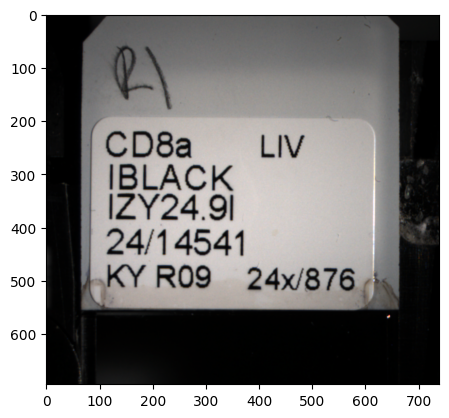

In [5]:
rgba_image = Image.open(file)
im_data = rgba_image.convert('RGB')
# Reduce the image to the lowest 
# number of dimensions. 
im_data = np.array(im_data)
plt.imshow(im_data)

----
### Letter segmentation

CD8a LIV
IBLACK

IZY24 9
24/14541

KY ROO = 24x/876



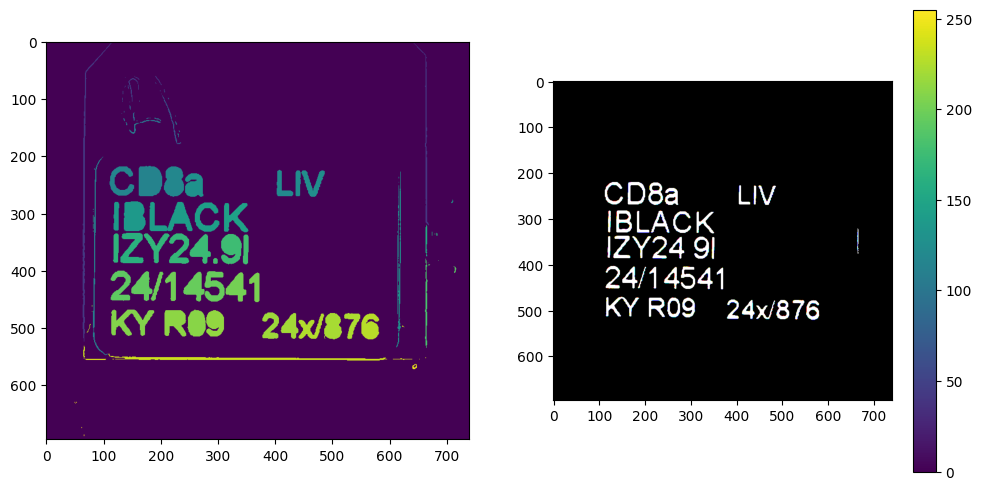

In [20]:
#######
# Perform edge detection
edges = skimage.filters.sobel( np.sum(im_data, axis = 2) )

#####
# Threshold the image to remove most of the 
# unimportant information from the image.

# Find the threshold values
threshold_val = skimage.filters.threshold_otsu(edges)
edges[edges < threshold_val] = 0

# Fill the binary masks of the letters
fill_string = scipy.ndimage.binary_fill_holes(edges)

# Invert the image and multiply by the letter
# mask to get only the letters in the image. 
invert = fill_string * skimage.util.invert( im_data[:, :, 0] )
#####
# Create a binary image from the inverted letters
binary = np.array(invert)
binary[binary>0] = 1

# create labels from the binary image. 
labels = skimage.measure.label(binary)

# Get properties of the letters and remaining masks. 
region_props = pd.DataFrame( skimage.measure.regionprops_table(
                labels, properties = {'label', 'area', 
                'axis_minor_length', 'axis_major_length'}) )

# Create a mask of zeros
filtered_image = np.zeros(im_data.shape)

# Loop around all labels. 
for i in range(region_props.shape[0]): 
    # Find the positon of mask i in the label image. 
    mask_pos = np.where(labels == region_props['label'].iloc[i])
    # Find the maximum and minimum height and width of the masks. 
    delta_x = np.abs( np.min(mask_pos[0]) - np.max(mask_pos[0]) ) 
    delta_y = np.abs( np.min(mask_pos[1]) - np.max(mask_pos[1]) ) 
    # If the mask is too long or high, remove 
    # Also remove if the area is too small. 
    if delta_x  <= 75 and delta_y <= 75 and region_props['area'].iloc[i] > 100: 
        # keep the mask. 
        filtered_image[mask_pos[0], mask_pos[1]] = skimage.util.invert(
                                    im_data[mask_pos[0], mask_pos[1], :] )

filtered_image = np.array(filtered_image, dtype = 'uint8')

filtered_image[filtered_image>150] = 255
filtered_image[filtered_image<150] = 0

# Show the results. 
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))
ax[0].imshow(labels)
h = ax[1].imshow(filtered_image)
plt.colorbar(h)

print(pytess.image_to_string(filtered_image))

In [13]:
im = Image.fromarray(filtered_image)
# im.save("your_file.jpeg")

In [10]:
np.max(filtered_image)

np.int64(255)

In [ ]:
'//data.beatson.gla.ac.uk/data/RCORBYN/User_Data/Current_Projects/20241118_PlateScanner/20250723_text_cropped/letters_' + os.path.basename(file)